데이터 로딩 및 전처리가 완료되었습니다. 이제 보고서에 제안된 시각화를 순서대로 생성합니다.


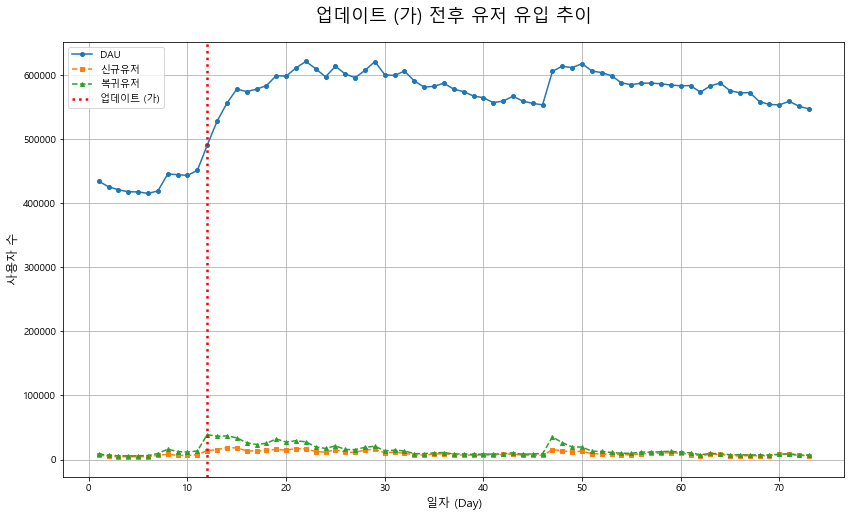

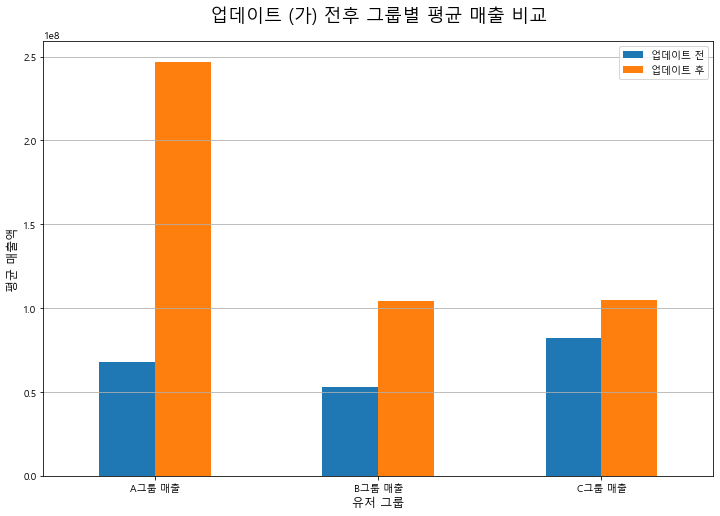

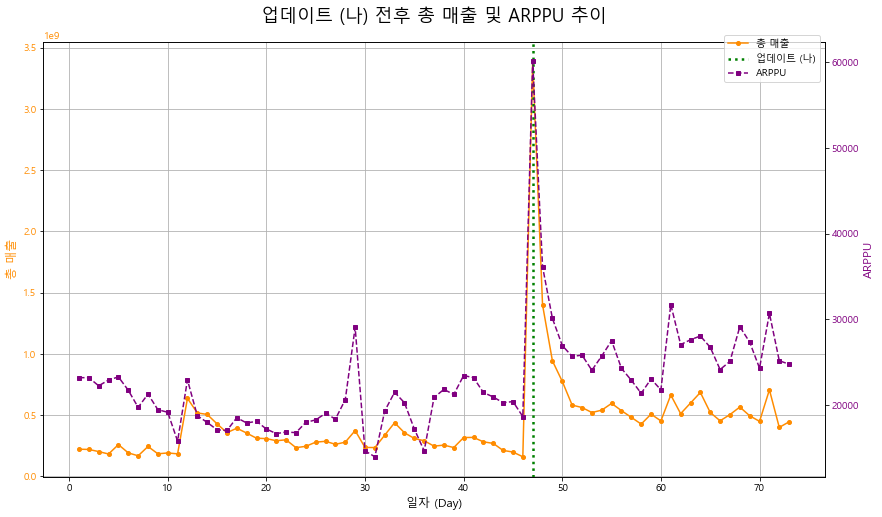

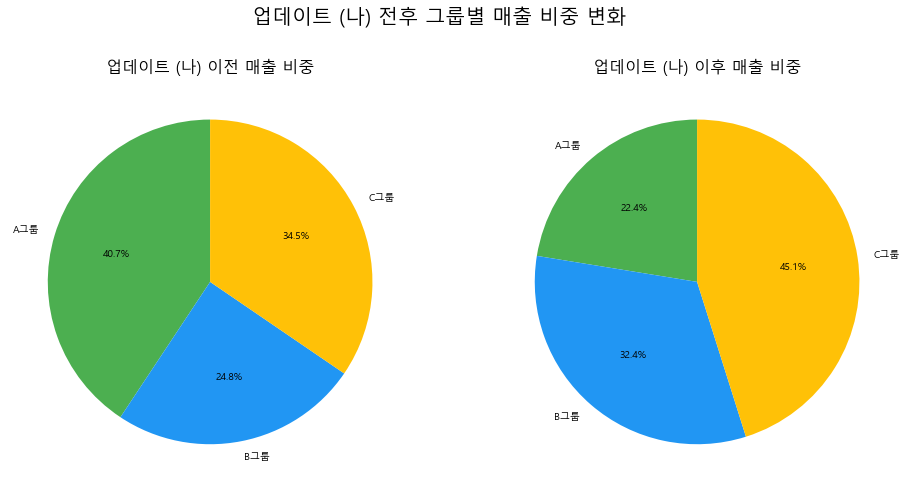

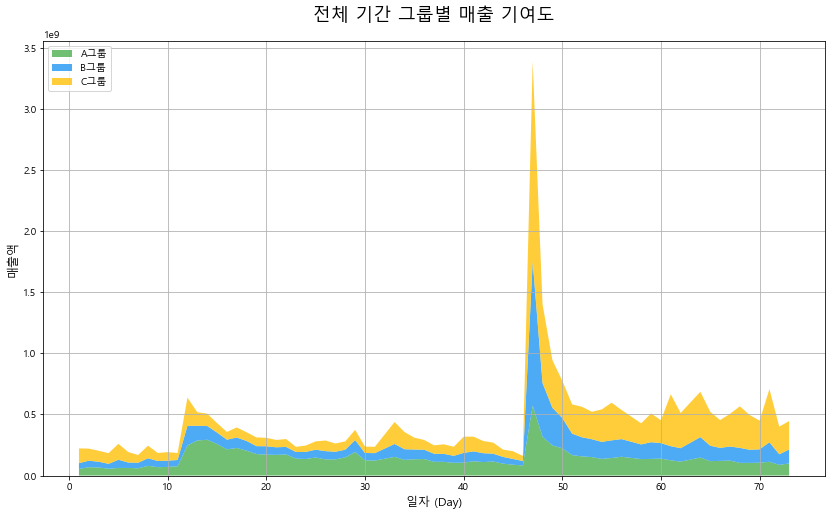

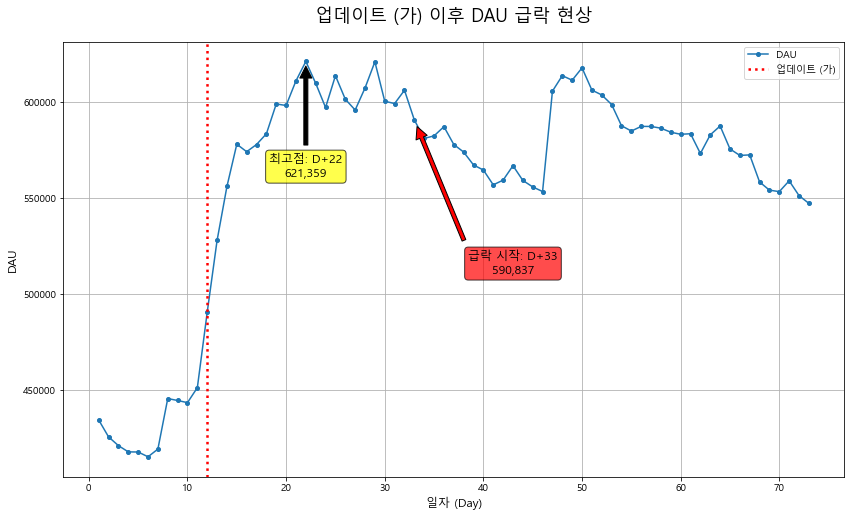

In [25]:

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
import sys

# --- 1. 기본 설정 및 데이터 로딩 ---

# 한글 폰트 설정
# Windows 환경에서는 'Malgun Gothic'을, macOS 환경에서는 'AppleGothic'을 사용합니다.
try:
    font_name = 'Malgun Gothic' if sys.platform == 'win32' else 'AppleGothic'
    plt.rc('font', family=font_name)
except Exception as e:
    print(f"한글 폰트를 찾을 수 없어 기본 폰트로 그래프를 생성합니다. 오류: {e}")
    pass
# 그래프에서 마이너스 부호가 깨지는 것을 방지합니다.
plt.rcParams['axes.unicode_minus'] = False

# CSV 파일 로드 및 전처리
# 'cp949' 인코딩으로 먼저 시도하고 실패하면 'utf-8'로 재시도합니다.
try:
    df = pd.read_csv('메엠과제.csv', encoding='cp949')
except UnicodeDecodeError:
    df = pd.read_csv('메엠과제.csv', encoding='utf-8')
except FileNotFoundError:
    print("오류: 파일을 찾을 수 없습니다. 스크립트와 같은 폴더에 파일을 저장했는지 확인하세요.")
    sys.exit()

# 숫자 컬럼들을 실제 숫자 타입으로 변환
# OverflowError를 방지하기 위해 pd.to_numeric을 사용하여 더 큰 숫자를 처리합니다.
cols_to_process = [
    '총 매출', 'DAU', '신규유저', '복귀유저', 'PU', 'A그룹 PU', 'B그룹 PU', 'C그룹 PU',
    'A그룹 매출', 'B그룹 매출', 'C그룹 매출', '유료재화 획득량', '유료재화 소비량'
]
for col in cols_to_process:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace(',', '', regex=False)
        df[col] = pd.to_numeric(df[col], errors='coerce', downcast='float')

# 분석용 컬럼 추가
df['일자_num'] = df['일자'].str.replace('D+', '', regex=False).astype(int)
df['ARPPU'] = (df['총 매출'] / df['PU']).replace([np.inf, -np.inf], 0).fillna(0)

print("데이터 로딩 및 전처리가 완료되었습니다. 이제 보고서에 제안된 시각화를 순서대로 생성합니다.")


# --- 2. 슬라이드별 시각화 코드 ---

# [Slide 3 요청 1] DAU, 신규/복귀 유저 추이 (꺾은선 그래프)
plt.figure(figsize=(14, 8))
plt.plot(df['일자_num'], df['DAU'], marker='o', markersize=4, linestyle='-', label='DAU')
plt.plot(df['일자_num'], df['신규유저'], marker='s', markersize=4, linestyle='--', label='신규유저')
plt.plot(df['일자_num'], df['복귀유저'], marker='^', markersize=4, linestyle='--', label='복귀유저')
plt.axvline(x=12, color='r', linestyle=':', linewidth=2.5, label='업데이트 (가)')
plt.title('업데이트 (가) 전후 유저 유입 추이', fontsize=18, pad=20)
plt.xlabel('일자 (Day)', fontsize=12)
plt.ylabel('사용자 수', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

# [Slide 3 요청 2] 업데이트 (가) 전후 그룹별 매출 비교 (막대 그래프)
before_update_a = df[(df['일자_num'] >= 5) & (df['일자_num'] <= 11)][['A그룹 매출', 'B그룹 매출', 'C그룹 매출']].mean()
after_update_a = df[(df['일자_num'] >= 12) & (df['일자_num'] <= 18)][['A그룹 매출', 'B그룹 매출', 'C그룹 매출']].mean()

update_a_revenue = pd.DataFrame({'업데이트 전': before_update_a, '업데이트 후': after_update_a})
update_a_revenue.plot(kind='bar', figsize=(12, 8), rot=0)
plt.title('업데이트 (가) 전후 그룹별 평균 매출 비교', fontsize=18, pad=20)
plt.ylabel('평균 매출액', fontsize=12)
plt.xlabel('유저 그룹', fontsize=12)
plt.grid(axis='y')
plt.show()


# [Slide 4 요청 1] 총 매출과 ARPPU 추이 (이중 축 꺾은선 그래프)
fig, ax1 = plt.subplots(figsize=(14, 8))
color1 = 'darkorange'
ax1.set_title('업데이트 (나) 전후 총 매출 및 ARPPU 추이', fontsize=18, pad=20)
ax1.set_xlabel('일자 (Day)', fontsize=12)
ax1.set_ylabel('총 매출', fontsize=12, color=color1)
ax1.plot(df['일자_num'], df['총 매출'], marker='o', markersize=4, color=color1, label='총 매출')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True)

ax2 = ax1.twinx()
color2 = 'purple'
ax2.set_ylabel('ARPPU', fontsize=12, color=color2)
ax2.plot(df['일자_num'], df['ARPPU'], marker='s', markersize=4, linestyle='--', color=color2, label='ARPPU')
ax2.tick_params(axis='y', labelcolor=color2)
ax1.axvline(x=47, color='g', linestyle=':', linewidth=2.5, label='업데이트 (나)')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
plt.show()

# [Slide 4 요청 2] 업데이트 (나) 전후 그룹별 매출 비중 비교 (원그래프)
before_update_b_sum = df[(df['일자_num'] >= 40) & (df['일자_num'] <= 46)][['A그룹 매출', 'B그룹 매출', 'C그룹 매출']].sum()
after_update_b_sum = df[(df['일자_num'] >= 47) & (df['일자_num'] <= 53)][['A그룹 매출', 'B그룹 매출', 'C그룹 매출']].sum()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
colors = ['#4CAF50', '#2196F3', '#FFC107']
labels = ['A그룹', 'B그룹', 'C그룹']

ax1.pie(before_update_b_sum, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
ax1.set_title('업데이트 (나) 이전 매출 비중', fontsize=16)

ax2.pie(after_update_b_sum, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
ax2.set_title('업데이트 (나) 이후 매출 비중', fontsize=16)

fig.suptitle('업데이트 (나) 전후 그룹별 매출 비중 변화', fontsize=20)
plt.show()


# [Slide 6 요청] 그룹별 누적 매출 기여도 (누적 영역형 그래프)
plt.figure(figsize=(14, 8))
revenues = [df['A그룹 매출'], df['B그룹 매출'], df['C그룹 매출']]
plt.stackplot(df['일자_num'], revenues, labels=labels, colors=colors, alpha=0.8)
plt.title('전체 기간 그룹별 매출 기여도', fontsize=18, pad=20)
plt.xlabel('일자 (Day)', fontsize=12)
plt.ylabel('매출액', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


# [Slide 8 요청] DAU 추이와 급락 지점 강조 (꺾은선 그래프)
# 주석의 가독성을 높이기 위해 위치를 조정하고, 소수점을 제거했습니다.
plt.figure(figsize=(14, 8))
plt.plot(df['일자_num'], df['DAU'], marker='o', markersize=4, linestyle='-', label='DAU')
plt.axvline(x=12, color='r', linestyle=':', linewidth=2.5, label='업데이트 (가)')
plt.title('업데이트 (가) 이후 DAU 급락 현상', fontsize=18, pad=20)
plt.xlabel('일자 (Day)', fontsize=12)
plt.ylabel('DAU', fontsize=12)

# DAU 최고점 강조 (D+22)
peak_day = 22
peak_dau = df.loc[df['일자_num'] == peak_day, 'DAU'].iloc[0]

plt.annotate(f'최고점: D+{peak_day}\n{int(peak_dau):,}',
             xy=(peak_day, peak_dau), xytext=(peak_day, peak_dau - 60000),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12, ha='center',
             bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="black", lw=1, alpha=0.7))

# DAU 급락 시작 지점 강조 (D+33)
trough_day = 33
trough_dau = df.loc[df['일자_num'] == trough_day, 'DAU'].iloc[0]

plt.annotate(f'급락 시작: D+{trough_day}\n{int(trough_dau):,}',
             xy=(trough_day, trough_dau), xytext=(trough_day + 10, trough_dau - 80000),
             arrowprops=dict(facecolor='red', shrink=0.05),
             fontsize=12, ha='center',
             bbox=dict(boxstyle="round,pad=0.3", fc="red", ec="black", lw=1, alpha=0.7))

plt.grid(True)
plt.legend()
plt.show()


데이터 로딩 및 전처리가 완료되었습니다. 이제 보고서에 제안된 시각화를 순서대로 생성합니다.


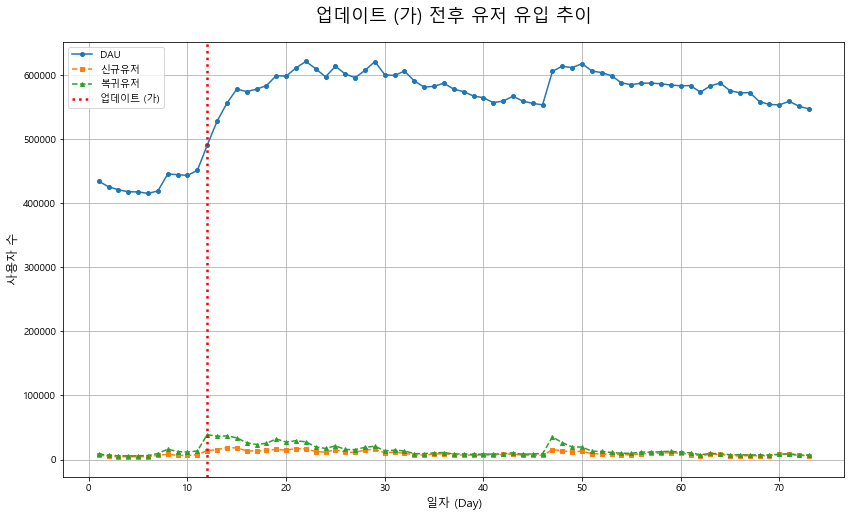

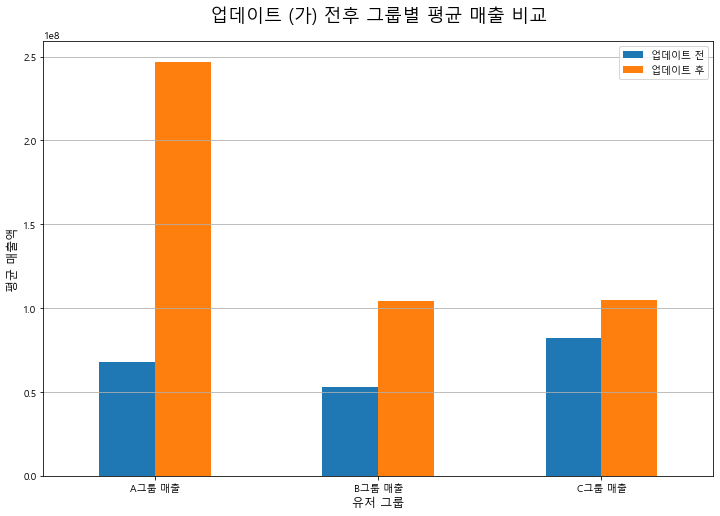

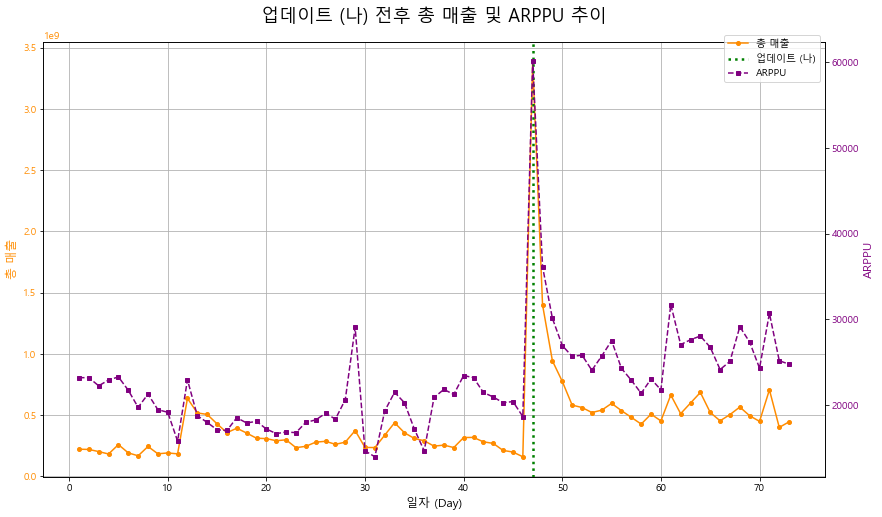

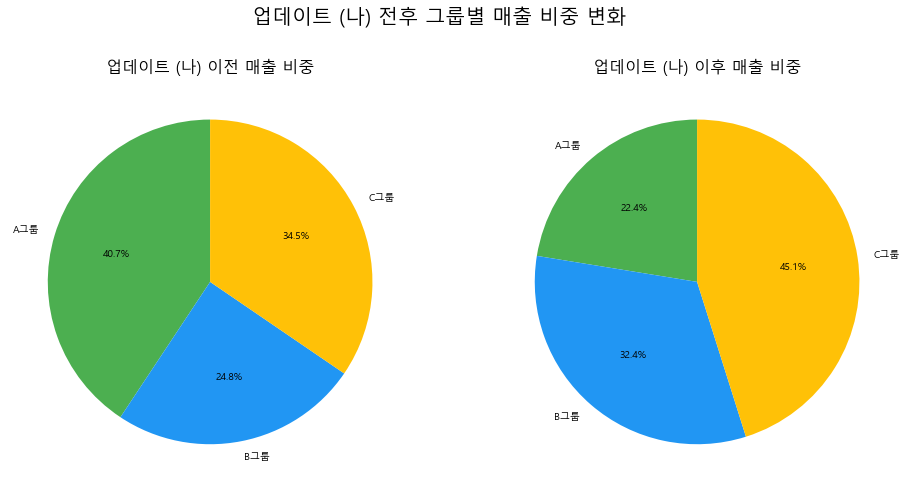

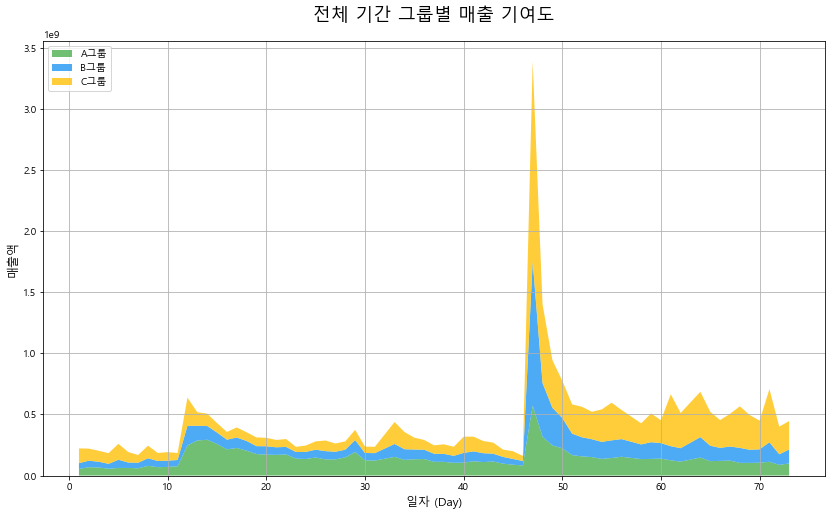

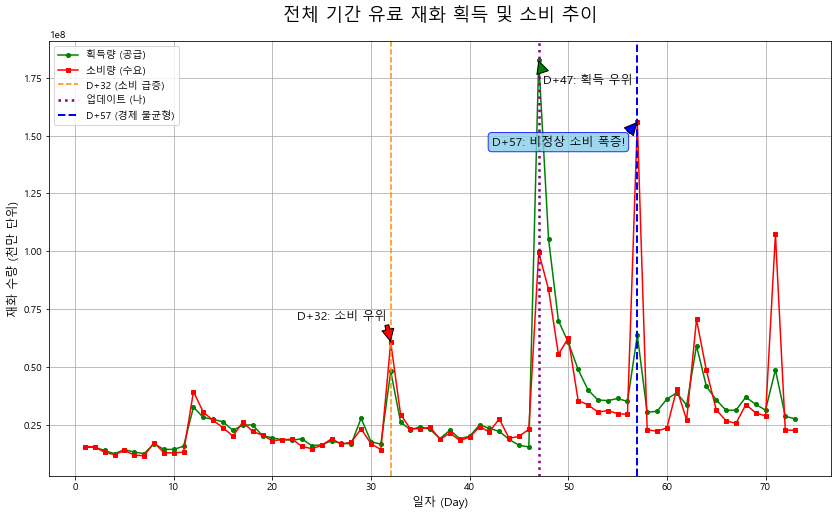

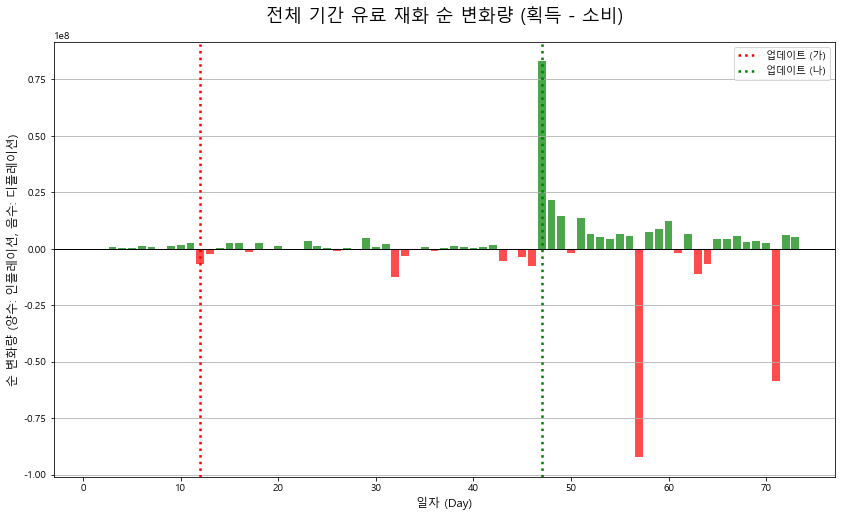

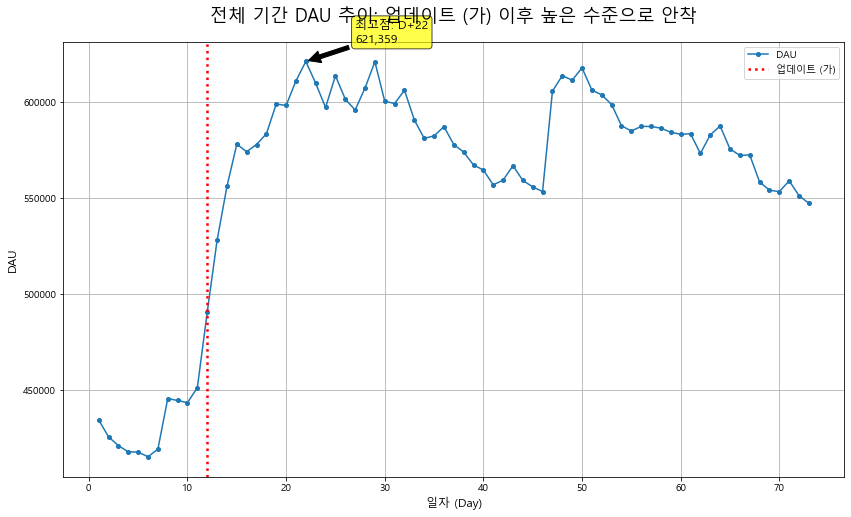

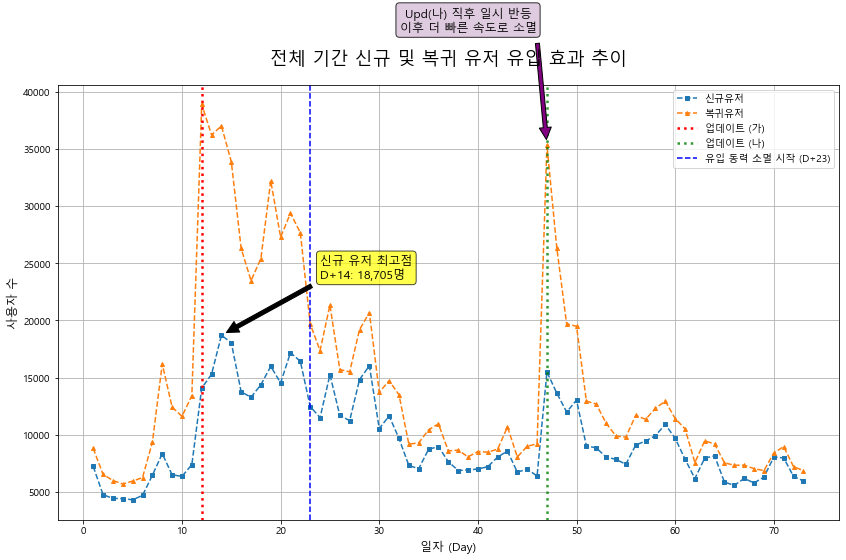

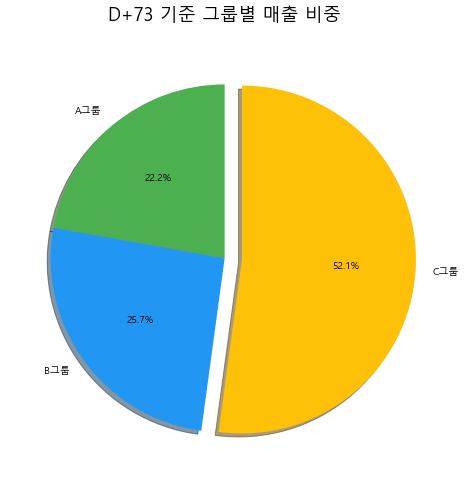

In [1]:
# -*- coding: utf-8 -*-
# 이 스크립트는  파일의 데이터를 읽어와 다양한 비즈니스 지표를 시각화합니다.
# pandas와 matplotlib 라이브러리가 필요합니다.
# pip install pandas matplotlib

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
import sys

# --- 1. 기본 설정 및 데이터 로딩 ---

# 한글 폰트 설정
# Windows 환경에서는 'Malgun Gothic'을, macOS 환경에서는 'AppleGothic'을 사용합니다.
try:
    font_name = 'Malgun Gothic' if sys.platform == 'win32' else 'AppleGothic'
    plt.rc('font', family=font_name)
except Exception as e:
    print(f"한글 폰트를 찾을 수 없어 기본 폰트로 그래프를 생성합니다. 오류: {e}")
    pass
# 그래프에서 마이너스 부호가 깨지는 것을 방지합니다.
plt.rcParams['axes.unicode_minus'] = False

# CSV 파일 로드 및 전처리
# 'cp949' 인코딩으로 먼저 시도하고 실패하면 'utf-8'로 재시도합니다.
try:
    df = pd.read_csv('.csv', encoding='cp949')
except UnicodeDecodeError:
    df = pd.read_csv('.csv', encoding='utf-8')
except FileNotFoundError:
    print("오류: '' 파일을 찾을 수 없습니다. 스크립트와 같은 폴더에 파일을 저장했는지 확인하세요.")
    sys.exit()

# 숫자 컬럼들을 실제 숫자 타입으로 변환
# OverflowError를 방지하기 위해 pd.to_numeric을 사용하여 더 큰 숫자를 처리합니다.
cols_to_process = [
    '총 매출', 'DAU', '신규유저', '복귀유저', 'PU', 'A그룹 PU', 'B그룹 PU', 'C그룹 PU',
    'A그룹 매출', 'B그룹 매출', 'C그룹 매출', '유료재화 획득량', '유료재화 소비량'
]
for col in cols_to_process:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace(',', '', regex=False)
        df[col] = pd.to_numeric(df[col], errors='coerce', downcast='float')

# 분석용 컬럼 추가
df['일자_num'] = df['일자'].str.replace('D+', '', regex=False).astype(int)
df['ARPPU'] = (df['총 매출'] / df['PU']).replace([np.inf, -np.inf], 0).fillna(0)
# 유료 재화 순 변화량 (획득 - 소비) 계산
df['순_재화_변화량'] = df['유료재화 획득량'] - df['유료재화 소비량']

print("데이터 로딩 및 전처리가 완료되었습니다. 이제 보고서에 제안된 시각화를 순서대로 생성합니다.")


# --- 2. 슬라이드별 시각화 코드 ---

# [Slide 3 요청 1] DAU, 신규/복귀 유저 추이 (꺾은선 그래프)
plt.figure(figsize=(14, 8))
plt.plot(df['일자_num'], df['DAU'], marker='o', markersize=4, linestyle='-', label='DAU')
plt.plot(df['일자_num'], df['신규유저'], marker='s', markersize=4, linestyle='--', label='신규유저')
plt.plot(df['일자_num'], df['복귀유저'], marker='^', markersize=4, linestyle='--', label='복귀유저')
plt.axvline(x=12, color='r', linestyle=':', linewidth=2.5, label='업데이트 (가)')
plt.title('업데이트 (가) 전후 유저 유입 추이', fontsize=18, pad=20)
plt.xlabel('일자 (Day)', fontsize=12)
plt.ylabel('사용자 수', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

# [Slide 3 요청 2] 업데이트 (가) 전후 그룹별 매출 비교 (막대 그래프)
before_update_a = df[(df['일자_num'] >= 5) & (df['일자_num'] <= 11)][['A그룹 매출', 'B그룹 매출', 'C그룹 매출']].mean()
after_update_a = df[(df['일자_num'] >= 12) & (df['일자_num'] <= 18)][['A그룹 매출', 'B그룹 매출', 'C그룹 매출']].mean()

update_a_revenue = pd.DataFrame({'업데이트 전': before_update_a, '업데이트 후': after_update_a})
update_a_revenue.plot(kind='bar', figsize=(12, 8), rot=0)
plt.title('업데이트 (가) 전후 그룹별 평균 매출 비교', fontsize=18, pad=20)
plt.ylabel('평균 매출액', fontsize=12)
plt.xlabel('유저 그룹', fontsize=12)
plt.grid(axis='y')
plt.show()


# [Slide 4 요청 1] 총 매출과 ARPPU 추이 (이중 축 꺾은선 그래프)
fig, ax1 = plt.subplots(figsize=(14, 8))
color1 = 'darkorange'
ax1.set_title('업데이트 (나) 전후 총 매출 및 ARPPU 추이', fontsize=18, pad=20)
ax1.set_xlabel('일자 (Day)', fontsize=12)
ax1.set_ylabel('총 매출', fontsize=12, color=color1)
ax1.plot(df['일자_num'], df['총 매출'], marker='o', markersize=4, color=color1, label='총 매출')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True)

ax2 = ax1.twinx()
color2 = 'purple'
ax2.set_ylabel('ARPPU', fontsize=12, color=color2)
ax2.plot(df['일자_num'], df['ARPPU'], marker='s', markersize=4, linestyle='--', color=color2, label='ARPPU')
ax2.tick_params(axis='y', labelcolor=color2)
ax1.axvline(x=47, color='g', linestyle=':', linewidth=2.5, label='업데이트 (나)')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
plt.show()

# [Slide 4 요청 2] 업데이트 (나) 전후 그룹별 매출 비중 비교 (원그래프)
before_update_b_sum = df[(df['일자_num'] >= 40) & (df['일자_num'] <= 46)][['A그룹 매출', 'B그룹 매출', 'C그룹 매출']].sum()
after_update_b_sum = df[(df['일자_num'] >= 47) & (df['일자_num'] <= 53)][['A그룹 매출', 'B그룹 매출', 'C그룹 매출']].sum()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
colors = ['#4CAF50', '#2196F3', '#FFC107']
labels = ['A그룹', 'B그룹', 'C그룹']

ax1.pie(before_update_b_sum, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
ax1.set_title('업데이트 (나) 이전 매출 비중', fontsize=16)

ax2.pie(after_update_b_sum, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
ax2.set_title('업데이트 (나) 이후 매출 비중', fontsize=16)

fig.suptitle('업데이트 (나) 전후 그룹별 매출 비중 변화', fontsize=20)
plt.show()


# [Slide 6 요청] 그룹별 누적 매출 기여도 (누적 영역형 그래프)
plt.figure(figsize=(14, 8))
revenues = [df['A그룹 매출'], df['B그룹 매출'], df['C그룹 매출']]
plt.stackplot(df['일자_num'], revenues, labels=labels, colors=colors, alpha=0.8)
plt.title('전체 기간 그룹별 매출 기여도', fontsize=18, pad=20)
plt.xlabel('일자 (Day)', fontsize=12)
plt.ylabel('매출액', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


# --- [Slide 7 요청 1] 유료 재화 획득/소비 추이 (이중 축 꺾은선 그래프) ---
fig, ax1 = plt.subplots(figsize=(14, 8))

ax1.set_title('전체 기간 유료 재화 획득 및 소비 추이', fontsize=18, pad=20)
ax1.set_xlabel('일자 (Day)', fontsize=12)
ax1.set_ylabel('재화 수량 (천만 단위)', fontsize=12)

# 획득량 (파란색)
ax1.plot(df['일자_num'], df['유료재화 획득량'], marker='o', markersize=4, color='green', label='획득량 (공급)')
# 소비량 (빨간색)
ax1.plot(df['일자_num'], df['유료재화 소비량'], marker='s', markersize=4, color='red', label='소비량 (수요)')

# 주요 불균형 시점 강조 (D+32, D+47, D+57)
ax1.axvline(x=32, color='darkorange', linestyle='--', linewidth=1.5, label='D+32 (소비 급증)')
ax1.axvline(x=47, color='purple', linestyle=':', linewidth=2.5, label='업데이트 (나)')
ax1.axvline(x=57, color='blue', linestyle='--', linewidth=2, label='D+57 (경제 불균형)')

# D+32 소비 급증 주석
d32_consume = df.loc[df['일자_num'] == 32, '유료재화 소비량'].iloc[0]
plt.annotate(f'D+32: 소비 우위',
             xy=(32, d32_consume), xytext=(32-5, d32_consume + 10000000),
             arrowprops=dict(facecolor='red', shrink=0.05),
             fontsize=12, ha='center')

# D+47 획득 우위 주석
d47_gain = df.loc[df['일자_num'] == 47, '유료재화 획득량'].iloc[0]
plt.annotate(f'D+47: 획득 우위',
             xy=(47, d47_gain), xytext=(47+5, d47_gain - 10000000),
             arrowprops=dict(facecolor='green', shrink=0.05),
             fontsize=12, ha='center')

# D+57 비정상 소비 급증 주석 추가
d57_consume = df.loc[df['일자_num'] == 57, '유료재화 소비량'].iloc[0]
plt.annotate(f'D+57: 비정상 소비 폭증!',
             xy=(57, d57_consume), xytext=(57-8, d57_consume - 10000000),
             arrowprops=dict(facecolor='blue', shrink=0.05),
             fontsize=12, ha='center',
             bbox=dict(boxstyle="round,pad=0.3", fc="skyblue", ec="blue", lw=1, alpha=0.8))


ax1.grid(True)
ax1.legend(loc='upper left')
plt.show()


# --- [Slide 7 요청 2] 유료 재화 순 변화량 (막대 그래프) ---
plt.figure(figsize=(14, 8))

# 순 변화량 막대 그래프
plt.bar(df['일자_num'], df['순_재화_변화량'], color=np.where(df['순_재화_변화량'] >= 0, 'green', 'red'), alpha=0.7)

plt.axhline(0, color='black', linestyle='-', linewidth=1) # 0 기준선
plt.axvline(x=12, color='r', linestyle=':', linewidth=2.5, label='업데이트 (가)')
plt.axvline(x=47, color='g', linestyle=':', linewidth=2.5, label='업데이트 (나)')

plt.title('전체 기간 유료 재화 순 변화량 (획득 - 소비)', fontsize=18, pad=20)
plt.xlabel('일자 (Day)', fontsize=12)
plt.ylabel('순 변화량 (양수: 인플레이션, 음수: 디플레이션)', fontsize=12)
plt.grid(axis='y')
plt.legend()
plt.show()


# --- [Slide 8 요청] DAU 안정화 및 유입 동력 소멸 강조 (전체 기간 반영) ---

# 1. DAU 추이 (전체 기간) - DAU 안정화 강조
plt.figure(figsize=(14, 8))
plt.plot(df['일자_num'], df['DAU'], marker='o', markersize=4, linestyle='-', label='DAU')
plt.axvline(x=12, color='r', linestyle=':', linewidth=2.5, label='업데이트 (가)')
plt.title('전체 기간 DAU 추이: 업데이트 (가) 이후 높은 수준으로 안착', fontsize=18, pad=20)
plt.xlabel('일자 (Day)', fontsize=12)
plt.ylabel('DAU', fontsize=12)

# D+22 최고점 강조 및 이후 안정화 시작 지점 표시
peak_day = 22
peak_dau = df.loc[df['일자_num'] == peak_day, 'DAU'].iloc[0]

plt.annotate(f'최고점: D+{peak_day}\n{int(peak_dau):,}',
             xy=(peak_day, peak_dau), xytext=(peak_day + 5, peak_dau + 10000),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12, ha='left',
             bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="black", lw=1, alpha=0.7))

plt.grid(True)
plt.legend()
plt.show()


# 2. 신규/복귀 유저 추이 (전체 기간) - 유입 효과 소멸 강조
plt.figure(figsize=(14, 8))
plt.plot(df['일자_num'], df['신규유저'], marker='s', markersize=4, linestyle='--', label='신규유저')
plt.plot(df['일자_num'], df['복귀유저'], marker='^', markersize=4, linestyle='--', label='복귀유저')
plt.axvline(x=12, color='r', linestyle=':', linewidth=2.5, label='업데이트 (가)')
# 업데이트 (나) 시점 추가
plt.axvline(x=47, color='g', linestyle=':', linewidth=2.5, label='업데이트 (나)', alpha=0.8)

# 유입 급감 시작 지점 (D+23) 강조
plt.axvline(x=23, color='b', linestyle='--', linewidth=1.5, label='유입 동력 소멸 시작 (D+23)')

plt.title('전체 기간 신규 및 복귀 유저 유입 효과 추이', fontsize=18, pad=20)
plt.xlabel('일자 (Day)', fontsize=12)
plt.ylabel('사용자 수', fontsize=12)

# 신규 유저 최고점 강조 (D+14)
peak_new_day = 14
peak_new_user = df.loc[df['일자_num'] == peak_new_day, '신규유저'].iloc[0]

plt.annotate(f'신규 유저 최고점\nD+{peak_new_day}: {int(peak_new_user):,}명',
             xy=(peak_new_day, peak_new_user), xytext=(peak_new_day + 10, peak_new_user + 5000),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12, ha='left',
             bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="black", lw=1, alpha=0.7))

# 업데이트 (나) 이후 반등 및 급속 소멸 강조 (D+47 이후)
try:
    # D+47 데이터 포인트를 기준으로 주석 위치 설정
    anchor_day = 47
    anchor_new = df.loc[df['일자_num'] == anchor_day, '신규유저'].iloc[0]
    anchor_return = df.loc[df['일자_num'] == anchor_day, '복귀유저'].iloc[0]
    anchor_y = max(anchor_new, anchor_return) 
    
    plt.annotate(f'Upd(나) 직후 일시 반등\n이후 더 빠른 속도로 소멸',
                 xy=(anchor_day, anchor_y), xytext=(anchor_day - 8, anchor_y + 10000), # 텍스트 위치를 D+47 근처로 조정
                 arrowprops=dict(facecolor='purple', shrink=0.05),
                 fontsize=12, ha='center',
                 bbox=dict(boxstyle="round,pad=0.3", fc="#d8bfd8", ec="black", lw=1, alpha=0.8))
except IndexError:
    # 데이터가 없을 경우를 대비하여 에러 처리 추가 (실제 데이터 범위에 따라 조정 필요)
    print("업데이트 (나) 이후 주석 처리를 위한 데이터 포인트를 찾을 수 없거나 데이터 범위가 부족합니다.")


plt.grid(True)
plt.legend()
plt.show()


# --- [추가 요청] D+73 기준 그룹별 매출 비중 (파이 차트) ---
# D+73 데이터 (df의 마지막 행)를 가져옵니다.
D73_data = df.iloc[-1][['A그룹 매출', 'B그룹 매출', 'C그룹 매출']]

# 파이 차트 생성
plt.figure(figsize=(10, 8))
colors = ['#4CAF50', '#2196F3', '#FFC107']
labels = ['A그룹', 'B그룹', 'C그룹']
explode = [0, 0, 0.1] # C그룹 강조

plt.pie(D73_data, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, explode=explode, shadow=True)
plt.title('D+73 기준 그룹별 매출 비중', fontsize=18, pad=20)

plt.show()


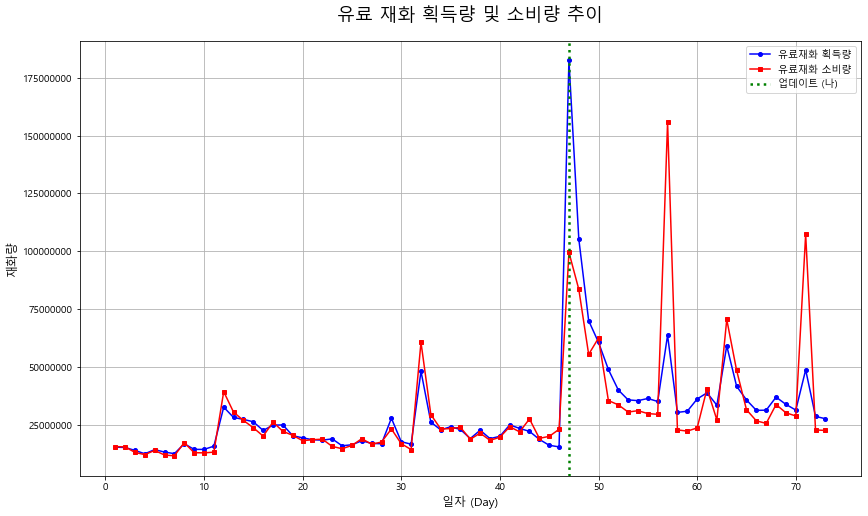

In [10]:
# [추가 요청 1] 유료 재화 획득량 vs. 소비량 추이 (D+57 문제 규명)
plt.figure(figsize=(14, 8))
plt.plot(df['일자_num'], df['유료재화 획득량'], marker='o', markersize=4, linestyle='-', label='유료재화 획득량', color='blue')
plt.plot(df['일자_num'], df['유료재화 소비량'], marker='s', markersize=4, linestyle='-', label='유료재화 소비량', color='red')
plt.axvline(x=47, color='g', linestyle=':', linewidth=2.5, label='업데이트 (나)')

plt.title('유료 재화 획득량 및 소비량 추이', fontsize=18, pad=20)
plt.xlabel('일자 (Day)', fontsize=12)
plt.ylabel('재화량', fontsize=12)


plt.grid(True)
plt.legend()
plt.ticklabel_format(axis='y', style='plain') # 지수 표기법 방지
plt.show()

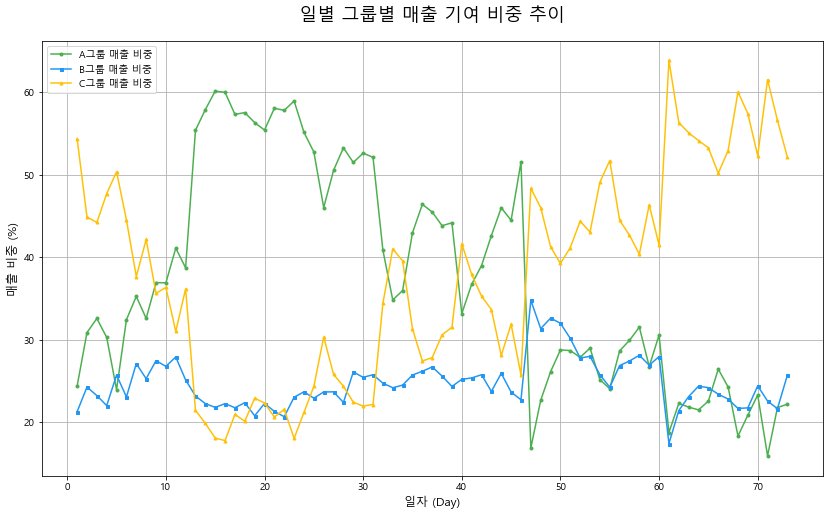

In [17]:
# [추가 요청 2] 그룹별 일평균 매출 기여 비중 추이
df['총 매출 합'] = df['A그룹 매출'] + df['B그룹 매출'] + df['C그룹 매출']
df['A그룹 비중'] = (df['A그룹 매출'] / df['총 매출 합']) * 100
df['B그룹 비중'] = (df['B그룹 매출'] / df['총 매출 합']) * 100
df['C그룹 비중'] = (df['C그룹 매출'] / df['총 매출 합']) * 100

plt.figure(figsize=(14, 8))
plt.plot(df['일자_num'], df['A그룹 비중'], marker='o', markersize=3, linestyle='-', label='A그룹 매출 비중', color='#4CAF50')
plt.plot(df['일자_num'], df['B그룹 비중'], marker='s', markersize=3, linestyle='-', label='B그룹 매출 비중', color='#2196F3')
plt.plot(df['일자_num'], df['C그룹 비중'], marker='^', markersize=3, linestyle='-', label='C그룹 매출 비중', color='#FFC107')


plt.title('일별 그룹별 매출 기여 비중 추이', fontsize=18, pad=20)
plt.xlabel('일자 (Day)', fontsize=12)
plt.ylabel('매출 비중 (%)', fontsize=12)


plt.grid(True)
plt.legend()
plt.show()

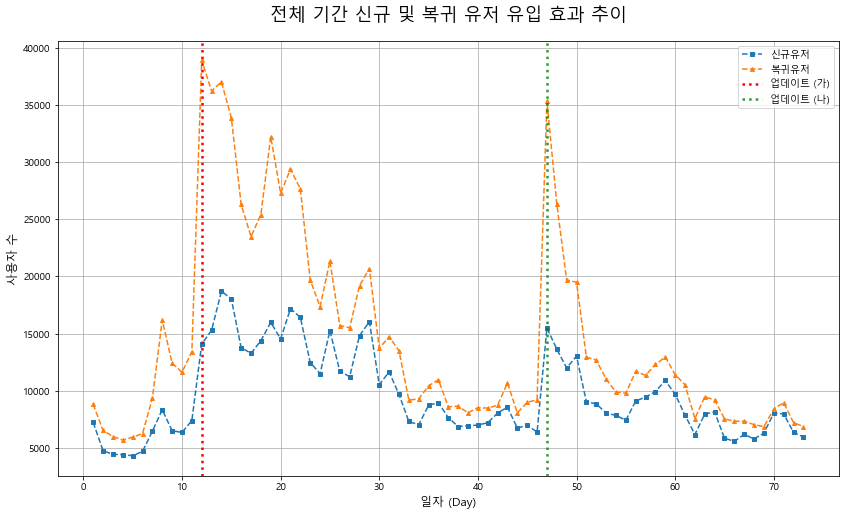

In [14]:
# 2. 신규/복귀 유저 추이 (전체 기간) - 유입 효과 소멸 강조
plt.figure(figsize=(14, 8))
plt.plot(df['일자_num'], df['신규유저'], marker='s', markersize=4, linestyle='--', label='신규유저')
plt.plot(df['일자_num'], df['복귀유저'], marker='^', markersize=4, linestyle='--', label='복귀유저')
plt.axvline(x=12, color='r', linestyle=':', linewidth=2.5, label='업데이트 (가)')
# 업데이트 (나) 시점 추가
plt.axvline(x=47, color='g', linestyle=':', linewidth=2.5, label='업데이트 (나)', alpha=0.8)

plt.title('전체 기간 신규 및 복귀 유저 유입 효과 추이', fontsize=18, pad=20)
plt.xlabel('일자 (Day)', fontsize=12)
plt.ylabel('사용자 수', fontsize=12)

plt.grid(True)
plt.legend()
plt.show()